# Hierarchical Clustering Asset Allocation with MlFinLab

## Abstract
The following notebook will explore MlFinLab's implementation of Thomas Raffinot's Hierarchical Equal Risk Contribution portfolio optimization technique. Users will be taken through how they can construct an optimal portfolio and the different risk metrics and linkage algorithms supported. Additionally, users will be able to see how they can create custom use cases with this library.

## Introduction
This tutorial will show users how to optimize a portfolio using the __[Hierarchical Equal Risk Contribution](https://ssrn.com/abstract=3237540)__ (HERC) optimization technique provided through the MlFinLab library. The HERC technique was developed by Thomas Raffinot in 2018, which built off his original __[Hierarchical Clustering Asset Allocation](https://ssrn.com/abstract=2840729)__ (HCAA) technique from 2017. The official documentation for this tutorial can be found __[here](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__. 


From Raffinot's 2018 paper on the HERC optimization technique, the following steps for implementation of the HCAA and HERC techniques were shown. 

Raffinot described the HCAA implementation in four steps:
1. Hierarchical clustering
2. Selecting the optimal number of clusters
3. Capital is allocated across clusters
4. Capital is allocated within clusters

HERC is built off this original implementation, combining the machine learning approach of the HCAA technique with the Top-Down recursive bisection approach from the __[Hierarchical Risk Parity](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/)__ algorithm. The HERC algorithm aims to diversify capital and risk allocations throughout the portfolio.

The steps for the HERC implementation are computed as:
1. Hierarchical clustering
2. Selecting the optimal number of clusters
3. Top-Down recursive bisection
4. Implement Naive Risk Parity within clusters to allocate weights to each asset

### Supported Allocation Metrics

The HERC implementation provided through MlFinLab currently supports the following metrics for calculating weight allocations:
1. 'minimum_variance': The variance of the clusters is used as a risk metric
2. 'minimum_standard_deviation': The standard deviation of the clusters is used as a risk metric
3. 'sharpe_ratio': The Sharpe ratio of the clusters is used as a risk metric
4. 'equal_weighting': All clusters are weighted equally with respect to the risk
5. 'expected_shortfall': The expected shortfall of the clusters is used as a risk metric
6. 'conditional_drawdown_risk': The conditional drawdown at risk of the clusters is used as a risk metric

### Supported Linkage Methods

Additionally, MlFinLab allows users to customize the type of linkage algorithm for the use of clustering. The current supported linkage methods are:
1. Single Linkage - the distance between two clusters is the minimum distance between any two points in the clusters
2. Complete Linkage - the distance between two clusters is the maximum of the distance between any two points in the clusters
3. Average Linkage - the distance between two clusters is the average of the distance between any two points in the clusters
4. Ward Linkage - the distance between two clusters is the increase of the squared error from when two clusters are merged

**The default linkage method in MlFinLab is set as the Ward Linkage method.** To learn more about the different types of linkage methods, please refer to Raffinot's paper on the __[HCAA method](https://ssrn.com/abstract=2840729)__ or to the __[official documentation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__. 

In [1]:
# Importing our required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import yfinance as yf
from mlfinlab.portfolio_optimization.hcaa import HierarchicalClusteringAssetAllocation

## The Data
All stock data in this tutorial was accesssed through the yfinance library. To learn more about the yfinance library and how to install it, please refer to the official project description __[here](https://pypi.org/project/yfinance/)__. In this tutorial, we will be working with 5-year historical closing-price data from Apple, Amazon, Facebook, Google, IBM, Microsoft, Netflix, Oracle, and Tesla. Note that the data must be in a Pandas dataframe indexed by date.


In [2]:
raw_prices = yf.download("AAPL AMZN FB MSFT NFLX TSLA GOOGL ORCL IBM", start='2015-01-01', end='2020-01-01')
stock_prices = raw_prices.iloc[::-1]
stock_prices = stock_prices['Close']
stock_prices.head()

[*********************100%***********************]  9 of 9 completed


,AAPL,AMZN,FB,GOOGL,IBM,MSFT,NFLX,ORCL,TSLA
Date,,,,,,,,,
2019-12-31,293.649994,1847.839966,205.250000,1339.390015,134.039993,157.699997,323.570007,52.980000,418.329987
2019-12-30,291.519989,1846.890015,204.410004,1339.709961,132.809998,157.589996,323.309998,52.700001,414.700012
2019-12-27,289.799988,1869.800049,208.100006,1354.640015,135.270004,158.960007,329.089996,53.459999,430.380005
2019-12-26,289.910004,1868.770020,207.789993,1362.469971,134.910004,158.669998,332.630005,53.570000,430.940002
2019-12-24,284.269989,1789.209961,205.119995,1344.430054,134.979996,157.380005,333.200012,53.439999,425.250000


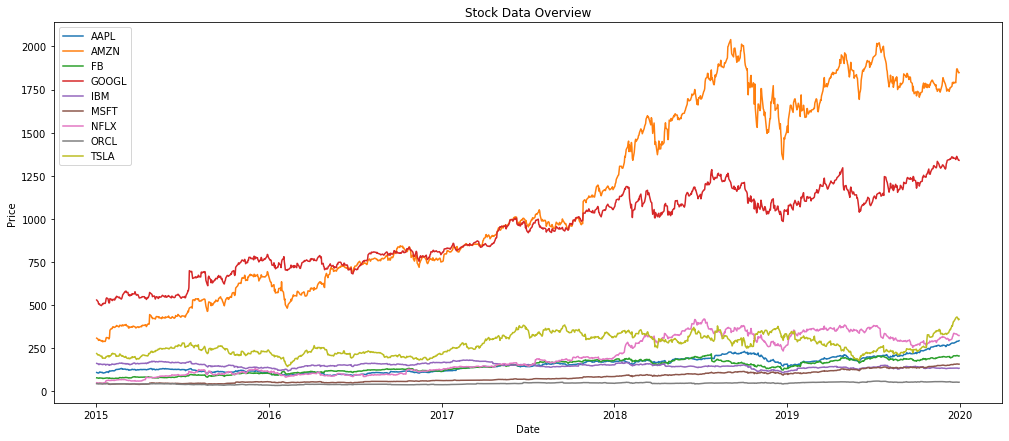

In [4]:
# Taking a quick look at our data
plt.figure(figsize=(17,7))
plt.plot(stock_prices)
plt.ylabel('Price')
plt.xlabel('Date')
plt.title('Stock Data Overview')
plt.legend(stock_prices.columns)
plt.show()

## Minimum Variance Portfolio
The Minimum Variance portfolio uses the variance of the clusters as a risk metric to calculate asset weights. In this example, we will also be showing the different effects of using the four different linkage algorithms. We will first be using the Single Linkage method, then the Complete Linkage method, followed by the Average Linkage method, and finally the Ward Linkage method. Keep in mind that the default linkage algorithm is set to the Ward Linkage algorithm.

Note that the allocate method for the HierarchicalClusteringAssetAllocation() object requires three parameters to run: 
1. asset_names (a list of strings containing the asset names)
2. asset_prices (a dataframe of historical asset prices - daily close)
3. allocation_metric (the type of solution/algorithm to use to calculate the weights)

Users can also specify: 
1. The type of linkage algorithm (shown below) 
2. The confidence level used for calculating expected shortfall and conditional drawdown at risk 
3. The optimal number of clusters for clustering
4. How to resample the prices

For simplicity, we will only be working with the three required parameters and also specifying our linkage algorithm of choice. For more detailed notes on this implementation, please refer to the __[official documentation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__. 

In [5]:
# HCAA implementation with minimum_variance solution - Single Linkage
hcaaMV_single = HierarchicalClusteringAssetAllocation()
hcaaMV_single.allocate(asset_names=stock_prices.columns,
                       asset_prices=stock_prices,
                       allocation_metric='minimum_variance',
                       linkage='single')

print("Minimum Variance Portfolio Weights - Single Linkage \n", hcaaMV_single.weights)

Minimum Variance Portfolio Weights - Single Linkage 
        TSLA       IBM     NFLX      ORCL      AAPL       FB     AMZN  \
0  0.004115  0.003099  0.00312  0.004641  0.344669  0.00474  0.01991   

      GOOGL     MSFT  
0  0.018846  0.59686  


In [6]:
# HCAA implementation with minimum_variance solution - Complete Linkage
hcaaMV_complete = HierarchicalClusteringAssetAllocation()
hcaaMV_complete.allocate(asset_names=stock_prices.columns,
                         asset_prices=stock_prices,
                         allocation_metric='minimum_variance',
                         linkage='complete')

print("Minimum Variance Portfolio Weights - Complete Linkage \n", hcaaMV_complete.weights)

Minimum Variance Portfolio Weights - Complete Linkage 
         IBM     ORCL     TSLA     NFLX      AAPL        FB      AMZN  \
0  0.078676  0.05924  0.05964  0.08873  0.288485  0.090621  0.029151   

      GOOGL      MSFT  
0  0.281124  0.024335  


In [7]:
# HCAA implementation with minimum_variance solution - Average Linkage
hcaaMV_average = HierarchicalClusteringAssetAllocation()
hcaaMV_average.allocate(asset_names=stock_prices.columns,
                        asset_prices=stock_prices,
                        allocation_metric='minimum_variance',
                        linkage='average')

print("Minimum Variance Portfolio Weights - Average Linkage \n", hcaaMV_average.weights)

Minimum Variance Portfolio Weights - Average Linkage 
        TSLA       IBM      ORCL      NFLX      AAPL        FB      AMZN  \
0  0.019747  0.014869  0.014969  0.022271  0.144173  0.022745  0.023872   

      GOOGL     MSFT  
0  0.140494  0.59686  


In [9]:
# HCAA implementation with minimum_variance solution - Ward Linkage
hcaaMV_ward = HierarchicalClusteringAssetAllocation()
hcaaMV_ward.allocate(asset_names=stock_prices.columns,
                         asset_prices=stock_prices,
                         allocation_metric='minimum_variance',
                         linkage='ward')

print("Minimum Variance Portfolio Weights - Ward Linkage \n", hcaaMV_ward.weights)

Minimum Variance Portfolio Weights - Ward Linkage 
        NFLX      AAPL        FB      AMZN     GOOGL     MSFT      TSLA  \
0  0.163349  0.122996  0.123826  0.184225  0.068371  0.18815  0.060523   

        IBM      ORCL  
0  0.066627  0.021933  


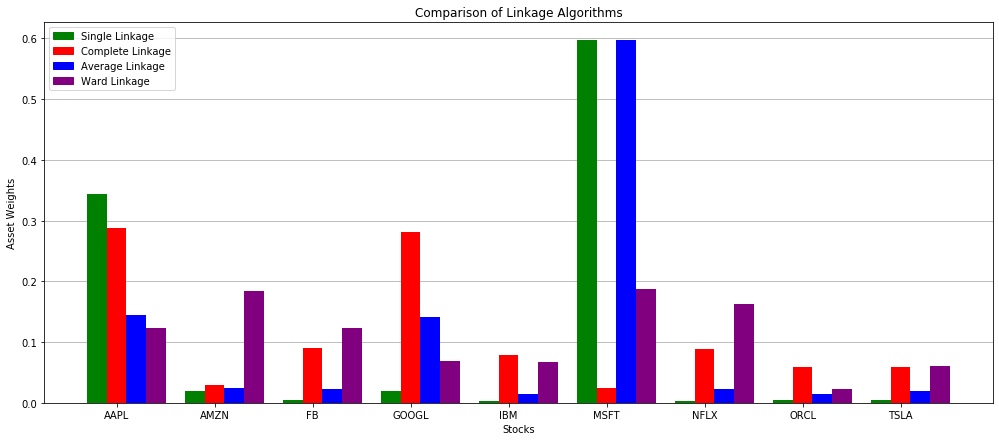

In [10]:
# Comparing our four Linkage algorithms
average = hcaaMV_average.weights[sorted(hcaaMV_average.weights)]
average = average.values.tolist()
average = [item for sublist in average for item in sublist]

complete = hcaaMV_complete.weights[sorted(hcaaMV_complete.weights)]
complete = complete.values.tolist()
complete = [item for sublist in complete for item in sublist]

single = hcaaMV_single.weights[sorted(hcaaMV_single.weights)]
single = single.values.tolist()
single = [item for sublist in single for item in sublist]

ward = hcaaMV_ward.weights[sorted(hcaaMV_ward.weights)]
ward = ward.values.tolist()
ward = [item for sublist in ward for item in sublist]

x = np.arange(len(average))
bar_width = 0.2

plt.figure(figsize=(17,7))
plt.bar(x, single, color='green', width=bar_width, zorder=2)
plt.bar(x + bar_width, complete, color='red', width=bar_width, zorder=2)
plt.bar(x + bar_width*2, average, color='blue', width=bar_width, zorder=2)
plt.bar(x + bar_width*3, ward, color='purple', width=bar_width, zorder=2)

plt.xticks(x + bar_width, sorted(hcaaMV_average.weights))
plt.title('Comparison of Linkage Algorithms')
plt.xlabel('Stocks')
plt.ylabel('Asset Weights')

green_patch = mpatches.Patch(color='green', label='Single Linkage')
red_patch = mpatches.Patch(color='red', label='Complete Linkage')
blue_patch = mpatches.Patch(color='blue', label='Average Linkage')
purple_patch=mpatches.Patch(color='purple', label='Ward Linkage')
plt.legend(handles=[green_patch, red_patch, blue_patch, purple_patch], loc='upper left')

plt.grid(axis='y')

plt.show()

Through this implementation, we can see how the four different linkage algorithms affect our optimal portfolio creation.

## Minimum Standard Deviation Portfolio
The Minimum Standard Deviation portfolio uses the standard deviation of the clusters as a risk metric to solve for the optimal portfolio. 

In [11]:
# HCAA implementation with minimum_standard_deviation solution
hcaaMSD = HierarchicalClusteringAssetAllocation()
hcaaMSD.allocate(asset_names=stock_prices.columns,
                 asset_prices=stock_prices,
                 allocation_metric='minimum_standard_deviation')

print("Minimum Standard Deviation Portfolio Weights \n", hcaaMSD.weights)

Minimum Standard Deviation Portfolio Weights 
        NFLX      AAPL        FB      AMZN    GOOGL      MSFT      TSLA  \
0  0.107983  0.024962  0.025131  0.037389  0.13068  0.038186  0.264432   

        IBM      ORCL  
0  0.129002  0.242235  


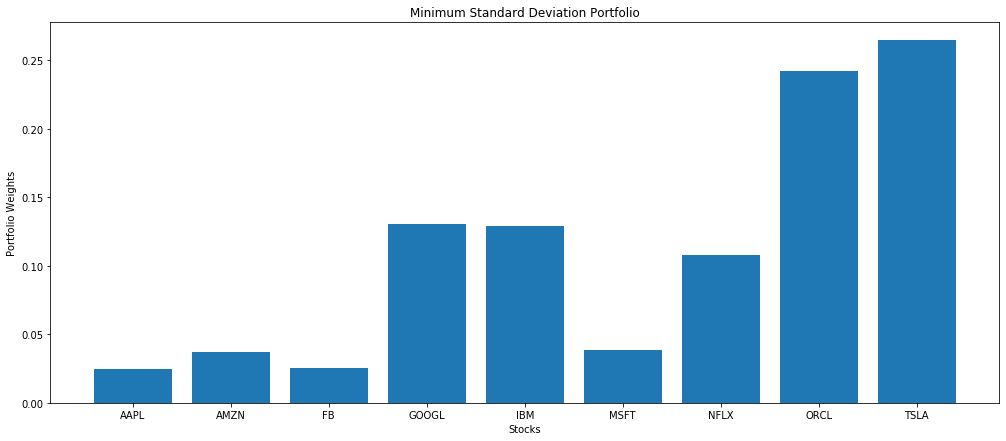

In [12]:
# Plotting our Minimum Standard Deviation portfolio
MSD_weights = hcaaMSD.weights[sorted(hcaaMSD.weights)]
MSD_weights = MSD_weights.values.tolist()
MSD_weights = [item for sublist in MSD_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(17,7))
plt.bar(y_pos, MSD_weights)
plt.xticks(y_pos, sorted(hcaaMSD.weights))
plt.xlabel('Stocks')
plt.ylabel('Portfolio Weights')
plt.title('Minimum Standard Deviation Portfolio')
plt.show()

## Sharpe Ratio Portfolio
The Sharpe ratio of the clusters is now used as a risk metric when constructing the optimal portfolio.

In [13]:
# HCAA implementation with sharpe_ratio solution
hcaaSR = HierarchicalClusteringAssetAllocation()
hcaaSR.allocate(asset_names=stock_prices.columns,
                asset_prices=stock_prices,
                allocation_metric='sharpe_ratio')

print("Sharpe Ratio Portfolio Weights \n", hcaaSR.weights)

Sharpe Ratio Portfolio Weights 
        NFLX      AAPL        FB      AMZN     GOOGL     MSFT      TSLA  \
0  0.163349  0.122996  0.123826  0.184225  0.068371  0.18815  0.060523   

        IBM      ORCL  
0  0.066627  0.021933  


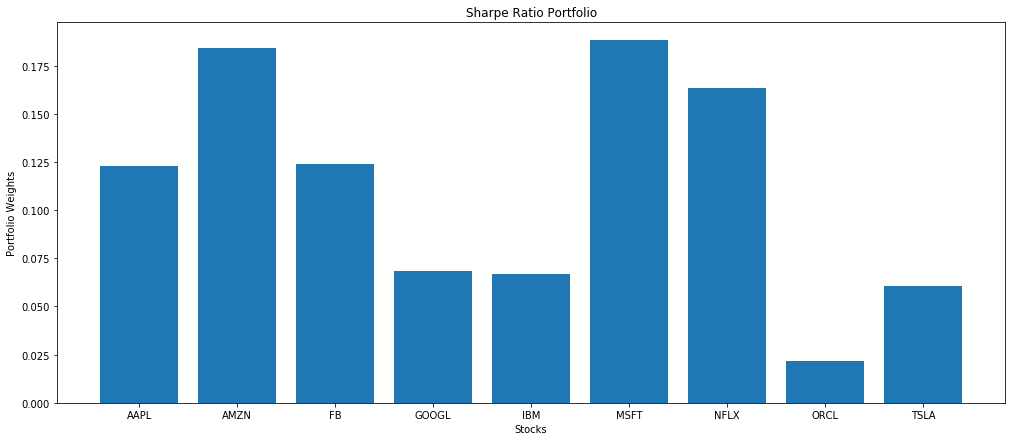

In [14]:
# Plotting our Sharpe ratio portfolio
SR_weights = hcaaSR.weights[sorted(hcaaSR.weights)]
SR_weights = SR_weights.values.tolist()
SR_weights = [item for sublist in SR_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(17,7))
plt.bar(y_pos, SR_weights)
plt.xticks(y_pos, sorted(hcaaSR.weights))
plt.xlabel('Stocks')
plt.ylabel('Portfolio Weights')
plt.title('Sharpe Ratio Portfolio')
plt.show()

## Equal Weighting Portfolio
In this example, all the clusters are weighted equally in terms of risk to construct our optimal portfolio.

In [16]:
# HCAA implementation with equal_weighting solution
hcaaEW = HierarchicalClusteringAssetAllocation()
hcaaEW.allocate(asset_names=stock_prices.columns,
                asset_prices=stock_prices,
                allocation_metric='equal_weighting')

print("Equal Weighting Portfolio Weights \n", hcaaEW.weights)

Equal Weighting Portfolio Weights 
        NFLX      AAPL        FB      AMZN     GOOGL      MSFT      TSLA  \
0  0.096878  0.072945  0.073437  0.109259  0.126615  0.111586  0.035895   

        IBM  ORCL  
0  0.123385  0.25  


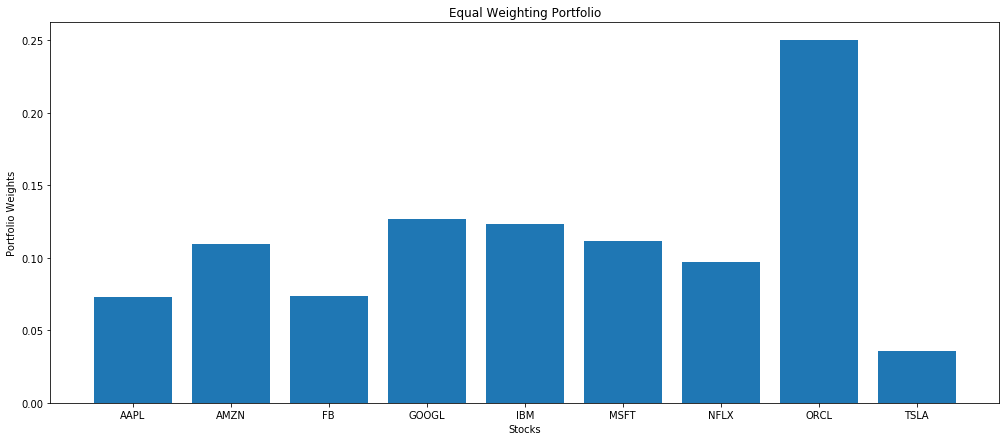

In [17]:
# Plotting our Equal Weighting portfolio
EW_weights = hcaaEW.weights[sorted(hcaaEW.weights)]
EW_weights = EW_weights.values.tolist()
EW_weights = [item for sublist in EW_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(17,7))
plt.bar(y_pos, EW_weights)
plt.xticks(y_pos, sorted(hcaaEW.weights))
plt.xlabel('Stocks')
plt.ylabel('Portfolio Weights')
plt.title('Equal Weighting Portfolio')
plt.show()

## Expected Shortfall Portfolio
The Expected Shortfall (CVaR) of the clusters is now being used as a risk metric to contruct our optimal portfolio.

In [18]:
# HCAA implementation with expected_shortfall solution
hcaaES = HierarchicalClusteringAssetAllocation()
hcaaES.allocate(asset_names=stock_prices.columns,
                asset_prices=stock_prices,
                allocation_metric='expected_shortfall')

print("Expected Shortfall Portfolio Weights \n", hcaaES.weights)

Expected Shortfall Portfolio Weights 
        NFLX      AAPL        FB      AMZN     GOOGL      MSFT      TSLA  \
0  0.144621  0.108894  0.109629  0.163103  0.092423  0.166578  0.053584   

        IBM      ORCL  
0  0.090064  0.071104  


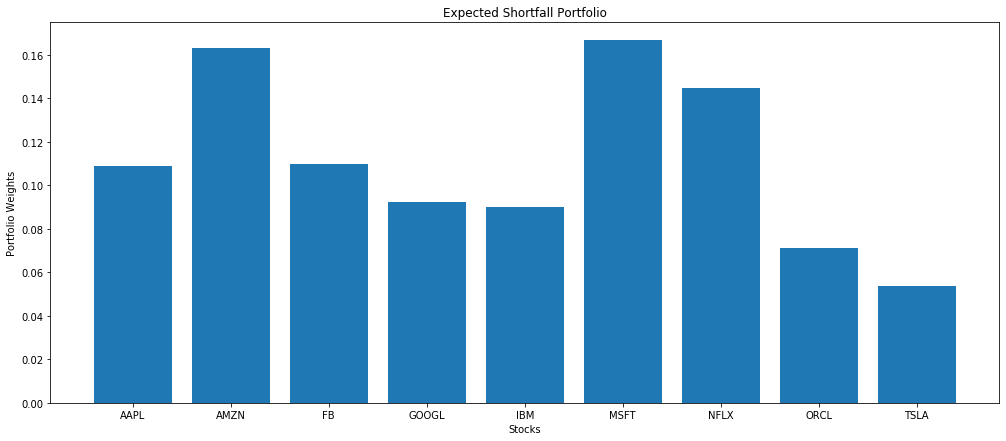

In [19]:
# Plotting our Expected Shortfall portfolio
ES_weights = hcaaES.weights[sorted(hcaaES.weights)]
ES_weights = ES_weights.values.tolist()
ES_weights = [item for sublist in ES_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(17,7))
plt.bar(y_pos, ES_weights)
plt.xticks(y_pos, sorted(hcaaES.weights))
plt.xlabel('Stocks')
plt.ylabel('Portfolio Weights')
plt.title('Expected Shortfall Portfolio')
plt.show()

## Conditional Drawdown at Risk Portfolio
The Conditional Drawdown at Risk (CDaR) of the clusters is used as a risk metric.

In [20]:
# HCAA implementation with conditional_drawdown_at_risk solution
hcaaCDR = HierarchicalClusteringAssetAllocation()
hcaaCDR.allocate(asset_names=stock_prices.columns,
                 asset_prices=stock_prices,
                 allocation_metric='conditional_drawdown_risk')

print("Conditional Drawdown at Risk Portfolio Weights \n", hcaaCDR.weights)

Conditional Drawdown at Risk Portfolio Weights 
        NFLX      AAPL       FB      AMZN     GOOGL      MSFT      TSLA  \
0  0.108033  0.030375  0.03058  0.045497  0.118906  0.046466  0.257438   

        IBM     ORCL  
0  0.106524  0.25618  


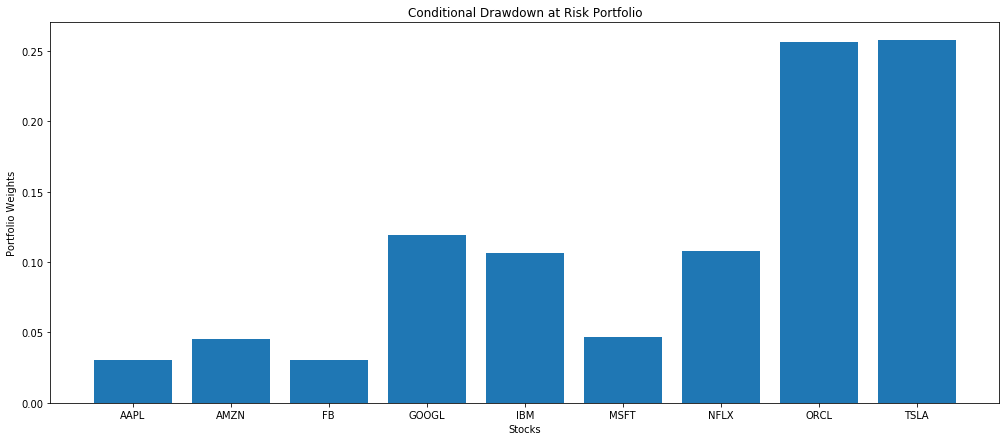

In [21]:
# Plotting our Conditional Drawdown at Risk portfolio
CDR_weights = hcaaCDR.weights[sorted(hcaaCDR.weights)]
CDR_weights = CDR_weights.values.tolist()
CDR_weights = [item for sublist in CDR_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(17,7))
plt.bar(y_pos, CDR_weights)
plt.xticks(y_pos, sorted(hcaaCDR.weights))
plt.xlabel('Stocks')
plt.ylabel('Portfolio Weights')
plt.title('Conditional Drawdown at Risk Portfolio')
plt.show()

## Comparison of Allocation Metrics
In the following graph, we can see how the portfolio weightings differ for each solution.

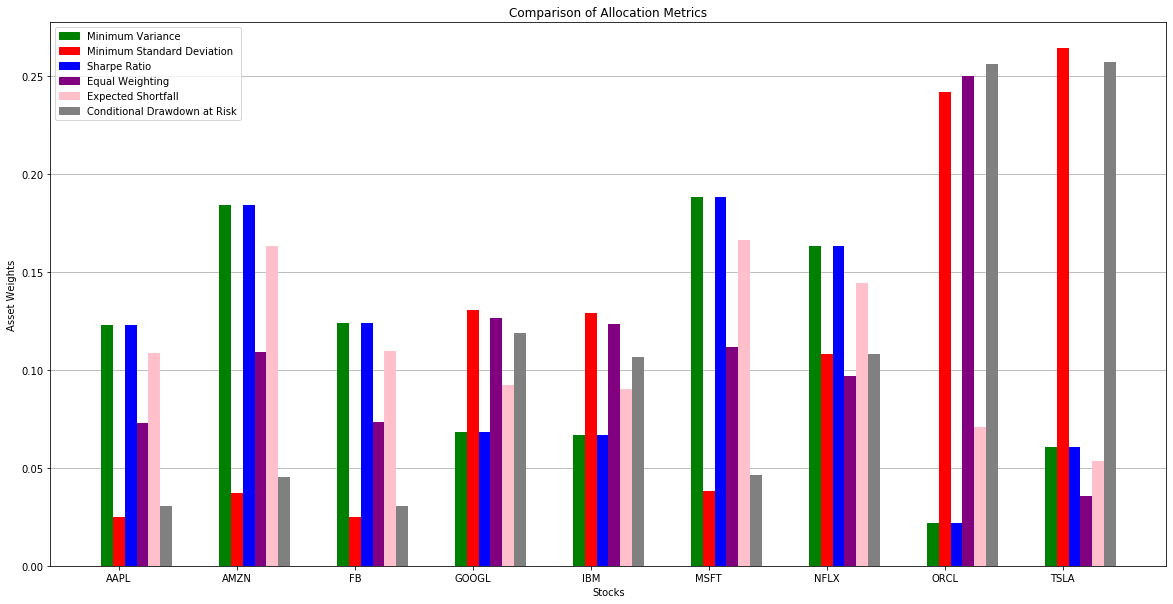

In [22]:
x = np.arange(len(ward))
bar_width = 0.1

plt.figure(figsize=(20,10))
plt.bar(x, ward, color='green', width=bar_width, zorder=2)
plt.bar(x + bar_width, MSD_weights, color='red', width=bar_width, zorder=2)
plt.bar(x + bar_width*2, SR_weights, color='blue', width=bar_width, zorder=2)
plt.bar(x + bar_width*3, EW_weights, color='purple', width=bar_width, zorder=2)
plt.bar(x + bar_width*4, ES_weights, color='pink', width=bar_width, zorder=2)
plt.bar(x + bar_width*5, CDR_weights, color='grey', width=bar_width, zorder=2)

plt.xticks(x + bar_width, sorted(hcaaMV_average.weights))
plt.title('Comparison of Allocation Metrics')
plt.xlabel('Stocks')
plt.ylabel('Asset Weights')

green_patch = mpatches.Patch(color='green', label='Minimum Variance')
red_patch = mpatches.Patch(color='red', label='Minimum Standard Deviation')
blue_patch = mpatches.Patch(color='blue', label='Sharpe Ratio')
purple_patch=mpatches.Patch(color='purple', label='Equal Weighting')
pink_patch = mpatches.Patch(color='pink', label='Expected Shortfall')
grey_patch=mpatches.Patch(color='grey', label='Conditional Drawdown at Risk')
plt.legend(handles=[green_patch, red_patch, blue_patch, purple_patch, pink_patch, grey_patch], loc='upper left')

plt.grid(axis='y')

plt.show()

## Custom Input from Users
MlFinLab also provides users with a lot of customizability when it comes to creating their optimal portfolios. Instead of providing the raw historical closing prices for the assets, users can input the asset returns, a covariance matrix of asset returns, and expected asset returns to calculate their optimal portfolio. If you would like to learn more about the customizbility within MlFinLab's HCAA implementation, please refer to the __[official documentation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__.

The following parameters in the allocate() method are utilized in order to construct a custom use case:
1. 'asset_returns': (pd.DataFrame/NumPy matrix) A matrix of asset returns
2. 'covariance_matrix': (pd.DataFrame/NumPy matrix) A covariance matrix of asset returns
3. 'expected_asset_returns: (list) A list of mean asset returns

To make some of the necessary calculations, we will make use of the ReturnsEstimation class provided by MlFinLab.

In [23]:
# Importing ReturnsEstimation class from MlFinLab
from mlfinlab.portfolio_optimization.returns_estimators import ReturnsEstimation

In [24]:
# Calculating our asset returns
returns = ReturnsEstimation.calculate_returns(stock_prices)
returns.head()

,AAPL,AMZN,FB,GOOGL,IBM,MSFT,NFLX,ORCL,TSLA
Date,,,,,,,,,
2019-12-30,-0.007254,-0.000514,-0.004093,0.000239,-0.009176,-0.000698,-0.000804,-0.005285,-0.008677
2019-12-27,-0.005900,0.012405,0.018052,0.011144,0.018523,0.008694,0.017878,0.014421,0.037810
2019-12-26,0.000380,-0.000551,-0.001490,0.005780,-0.002661,-0.001824,0.010757,0.002058,0.001301
2019-12-24,-0.019454,-0.042573,-0.012850,-0.013241,0.000519,-0.008130,0.001714,-0.002427,-0.013204
2019-12-23,-0.000950,0.002118,0.005168,0.004612,0.004223,0.000191,-0.000300,0.005052,-0.014180


In [25]:
# Calculating our covariance matrix
cov = returns.cov()
cov

,AAPL,AMZN,FB,GOOGL,IBM,MSFT,NFLX,ORCL,TSLA
AAPL,0.000247,0.000143,0.000130,0.000123,0.000082,0.000132,0.000154,0.000090,0.000133
AMZN,0.000143,0.000329,0.000187,0.000175,0.000081,0.000166,0.000235,0.000088,0.000164
FB,0.000130,0.000187,0.000326,0.000161,0.000068,0.000136,0.000191,0.000087,0.000151
GOOGL,0.000123,0.000175,0.000161,0.000219,0.000080,0.000144,0.000184,0.000084,0.000125
IBM,0.000082,0.000081,0.000068,0.000080,0.000172,0.000094,0.000093,0.000086,0.000093
MSFT,0.000132,0.000166,0.000136,0.000144,0.000094,0.000215,0.000171,0.000104,0.000130
NFLX,0.000154,0.000235,0.000191,0.000184,0.000093,0.000171,0.000668,0.000109,0.000222
ORCL,0.000090,0.000088,0.000087,0.000084,0.000086,0.000104,0.000109,0.000176,0.000097
TSLA,0.000133,0.000164,0.000151,0.000125,0.000093,0.000130,0.000222,0.000097,0.000800


In [26]:
# Calculating our mean asset returns
mean_returns = ReturnsEstimation.calculate_mean_historical_returns(stock_prices)
mean_returns

AAPL    -0.166973
AMZN    -0.316871
FB      -0.152249
GOOGL   -0.158188
IBM      0.059573
MSFT    -0.216532
NFLX    -0.290067
ORCL    -0.013684
TSLA    -0.028971
dtype: float64

In [27]:
# From here, we can now create our portfolio
hcaa_custom = HierarchicalClusteringAssetAllocation()
hcaa_custom.allocate(asset_names=stock_prices.columns,
                     asset_returns=returns,
                     covariance_matrix=cov, 
                     expected_asset_returns=mean_returns,
                     allocation_metric='conditional_drawdown_risk')

print("Custom HCAA Portfolio - Conditional Drawdown at Risk \n", hcaa_custom.weights)

Custom HCAA Portfolio - Conditional Drawdown at Risk 
       NFLX      AAPL        FB      AMZN    GOOGL      MSFT      TSLA  \
0  0.15038  0.113231  0.113995  0.169599  0.08536  0.173212  0.055718   

        IBM      ORCL  
0  0.083182  0.055322  


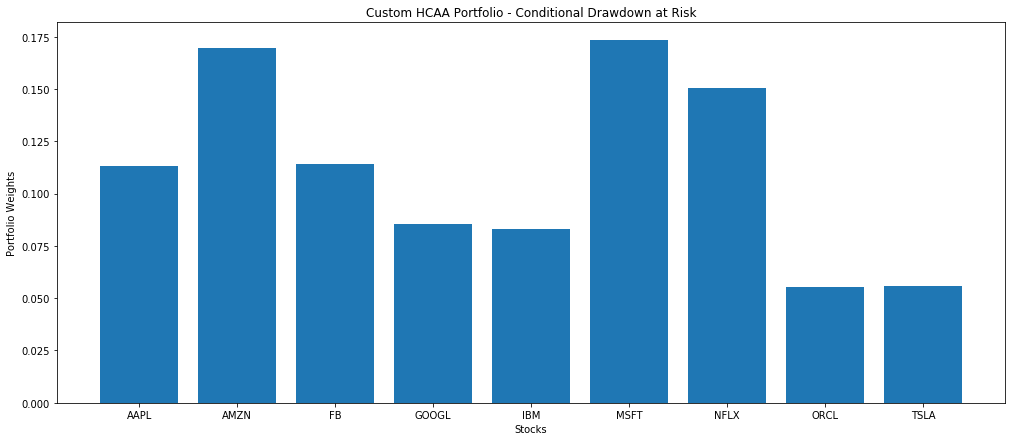

In [28]:
# Plotting our custom portfolio
custom_weights = hcaa_custom.weights[sorted(hcaa_custom.weights)]
custom_weights = custom_weights.values.tolist()
custom_weights = [item for sublist in custom_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(17,7))
plt.bar(y_pos, custom_weights)
plt.xticks(y_pos, sorted(hcaa_custom.weights))
plt.xlabel('Stocks')
plt.ylabel('Portfolio Weights')
plt.title('Custom HCAA Portfolio - Conditional Drawdown at Risk')
plt.show()

Through this implementation, we can see alternative ways of which users can construct an optimal portfolio using the HCAA techniques implemented by MlFinLab.

## Conclusion
Throughout this notebook, we saw how we can apply Raffinot's work from his Hierarchical Equal Risk Contribution technique through the MlFinLab library. We worked through how we can specify many different parameters to solve for our optimal portfolio, including chaning our risk metrics and the type of linkage algorithms being used for clustering. Users were also made aware of how they can customize their input to have more control over their calculations. If you would like to learn more about the HERC technique, please refer to Raffinot's original HERC paper linked at the top of this notebook. Additionally, please refer to the official documentation for this tutorial which can be found __[at this link](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__ if you have any further questions.